## Applied Deep Learning Term Project

### Analysis code

- Python code & result

- Hae-yong Joung (2019311266)

- - - 

### 0. Environment

In [1]:
import requests as req
from bs4 import BeautifulSoup as bs
import os
from selenium import webdriver
import pandas as pd
from html_table_parser import parser_functions as parser
import numpy as np
import csv
from konlpy.tag import Twitter 
from konlpy.tag import Okt
from collections import Counter
import pandas as pd
import numpy as np
import warnings

import theano
import pickle
from collections import defaultdict
import sys, re
import pandas as pd
import csv
import getpass
import gensim

from keras import layers
from keras import models
from keras.layers import Input, Embedding
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, Conv2D,Convolution2D, MaxPooling2D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, merge

import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')
okt = Okt()

os.getcwd()
os.chdir('C:\\Users\\JYW\\OneDrive - 연세대학교 (Yonsei University)\\정해용\\2020 1학기\\딥러닝응용\\project')
# should change the directory

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\JYW\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.


- - - 

### 1. Data preprocessing

In [2]:
os.chdir('C:\\Users\\JYW\\OneDrive - 연세대학교 (Yonsei University)\\정해용\\2020 1학기\\딥러닝응용\\project')

dataset = pd.read_csv('newstitle_타이거즈.csv')
dataset.head()

,date,title,cPOS
0,2019.04.01,"{'깜짝 7K KIA 황인준에게 두번째 선발 기회가 올까', 'KIA 불펜 희망으로...",1
1,2019.04.02,"{'KIA 주간전망-호랑이 군단, 라이벌 삼성·키움과 정면대결', 'KIA 이명기의...",0
2,2019.04.03,"{""또 다시 미뤄진 KIA '괴물루키' 김기훈 프로 데뷔 선발승, 삼성전 6이닝 4...",0
3,2019.04.04,"{""KIA 선발 양현종 '역투'"", ""KIA 최형우, 적시타 '달려'"", 'KIA ...",1
4,2019.04.05,"{""KIA 이명기 '이게 홈런의 맛'"", ""'이명기 결승 홈런' KIA, 키움 꺾고...",1


- Let's tokenize the text

In [3]:
exec(open('DL_project_source.py').read()) # to use predetermined hard-coding functions 

dataset['title_tokken'] = dataset['title'].apply(tokenizer_okt_pos)
dataset['title_imp_tokken'] = dataset['title_tokken'].apply(imp_tokken)
dataset["length"] = [len(str(dataset.title[i]).split(",")) for i in range(0,len(dataset))]

count = Counter(list_appending(dataset['title_imp_tokken']))
vocab = dict(count.most_common())
num_words =  [len(word) for word in dataset.title_imp_tokken]

max_l = np.max(num_words)
max_s = np.max(dataset["length"])

dataset.head()

,date,title,cPOS,title_tokken,title_imp_tokken,length
0,2019.04.01,"{'깜짝 7K KIA 황인준에게 두번째 선발 기회가 올까', 'KIA 불펜 희망으로...",1,"[({', Punctuation), (깜짝, Noun), (7, Number), (...","[깜짝, 황인준, 두번째, 선발, 기회, 불펜, 희망, 핫, 준영, 이번, 주, 승...",18
1,2019.04.02,"{'KIA 주간전망-호랑이 군단, 라이벌 삼성·키움과 정면대결', 'KIA 이명기의...",0,"[({', Punctuation), (KIA, Alpha), (주간, Noun), ...","[주간, 전망, 호랑이, 군단, 라이벌, 삼성, 정면, 대결, 이명기, 역, 발상,...",39
2,2019.04.03,"{""또 다시 미뤄진 KIA '괴물루키' 김기훈 프로 데뷔 선발승, 삼성전 6이닝 4...",0,"[({"", Punctuation), (또, Noun), (다시, Noun), (미뤄...","[또, 다시, 괴물, 루키, 김기훈, 프로, 데뷔, 선발, 승, 성전, 이닝, 실점...",30
3,2019.04.04,"{""KIA 선발 양현종 '역투'"", ""KIA 최형우, 적시타 '달려'"", 'KIA ...",1,"[({"", Punctuation), (KIA, Alpha), (선발, Noun), ...","[선발, 양현종, 역투, 최형우, 적시타, 선, 불, 리드, 오프, 적임, 누구, ...",32
4,2019.04.05,"{""KIA 이명기 '이게 홈런의 맛'"", ""'이명기 결승 홈런' KIA, 키움 꺾고...",1,"[({"", Punctuation), (KIA, Alpha), (이명기, Noun),...","[이명기, 이, 홈런, 맛, 이명기, 결승, 홈런, 연패, 탈출, 안치홍, 안타, ...",39


In [4]:
print("data loaded!")
print("number of documents:",str(len(dataset)))
print("vocab size:",str(len(vocab)))
print("max article length:",str(max_l))
print("max article number:",str(max_s))

data loaded!
number of documents: 183
vocab size: 3495
max article length: 296
max article number: 76


- Making embedding matrix and index with pretrained korean word2vec model

In [5]:
w2v_file = ".//ko.bin"

ko_model = gensim.models.Word2Vec.load(w2v_file)
print('%s words vectors in Korean word2vec bin file' % len(ko_model.wv.vocab))

30185 words vectors in Korean word2vec bin file


In [6]:
w2v_original = load_bin_vec_kor(w2v_file, vocab)

add_unknown_words(w2v_original, vocab) # add undedifined word in w2v model
W, word_idx_map = get_W(w2v_original)

print('Word embedding matrix shape: ',W.shape)

Word embedding matrix shape:  (3496, 200)


- Split train and valid dataset
- Train : 150 / Valid : 33 articles

In [7]:
# Making word index dataset and labels

X, Y = [], []
filter_h = 3
pad = filter_h - 1

for idx in range(len(dataset)):
    status = dataset["title_imp_tokken"][idx]

    words = status
    words_set = set(words)
    y=[]
    for i in range(pad):
        y.append(0)
    for word in words_set:
        if word in word_idx_map:
            y.append(word_idx_map[word])

    while len(y) < max_l+pad:
        y.append(0)

    X.append(y)
    Y.append(dataset["cPOS"][idx])

In [8]:
# Split dataset

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

indices = np.arange(dataset.shape[0])
np.random.shuffle(indices)
X = X.iloc[indices]
Y = Y.iloc[indices]

x_train = X[:150]
y_train = Y[:150]
x_val = X[150:183]
y_val = Y[150:183]

In [9]:
print("Train set:",str(len(x_train)))
print("Valid set:",str(len(x_val)))

Train set: 150
Valid set: 33


- - - 
### 2. Original Model Architecture

- Using 3 n-gram filters (n=1,2,3)
- Loss function : Negative log likelihood (binary cross-entropy)
- Optimizer : Adadelta
- Metrics : Accuracy
- Epochs : 50

In [10]:
input_size = max_l+pad # for Input layers
max_vocab_size = len(vocab) + 1 # for Embedding layers

main_input = Input(shape=(input_size,), dtype='int32')
sequential_1 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_1 = Conv1D(200, 1, activation='relu')(sequential_1)
sequential_1 = MaxPooling1D(1)(sequential_1)
sequential_1 = Flatten()(sequential_1)

sequential_2 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_2 = Conv1D(200, 2, activation='relu')(sequential_2)
sequential_2 = MaxPooling1D(1)(sequential_2)
sequential_2 = Flatten()(sequential_2)

sequential_3 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_3 = Conv1D(200, 3, activation='relu')(sequential_3)
sequential_3 = MaxPooling1D(1)(sequential_3)
sequential_3 = Flatten()(sequential_3)

merged = layers.concatenate([sequential_1, sequential_2, sequential_3])
dense = Dense(100, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=main_input, outputs=outputs)    

model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(x_val, y_val))

Train on 150 samples, validate on 33 samples
Epoch 1/50
150/150 [==============================] - 7s 44ms/step - loss: 0.7025 - accuracy: 0.5133 - val_loss: 0.6895 - val_accuracy: 0.5758
Epoch 2/50
150/150 [==============================] - 5s 36ms/step - loss: 0.6801 - accuracy: 0.6467 - val_loss: 0.6645 - val_accuracy: 0.6364
Epoch 3/50
150/150 [==============================] - 5s 35ms/step - loss: 0.6306 - accuracy: 0.6867 - val_loss: 0.7968 - val_accuracy: 0.3636
Epoch 4/50
150/150 [==============================] - 5s 33ms/step - loss: 0.5562 - accuracy: 0.7467 - val_loss: 0.7836 - val_accuracy: 0.4545
Epoch 5/50
150/150 [==============================] - 5s 36ms/step - loss: 0.4034 - accuracy: 0.8733 - val_loss: 1.2588 - val_accuracy: 0.3636
Epoch 6/50
150/150 [==============================] - 6s 39ms/step - loss: 0.3191 - accuracy: 0.8933 - val_loss: 0.7428 - val_accuracy: 0.4848
Epoch 7/50
150/150 [==============================] - 5s 36ms/step - loss: 0.1237 - accuracy: 1.0

- Visualize loss function & accuracy by epoch size

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
np.mean(val_acc)

epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

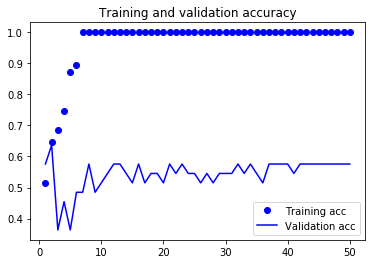

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

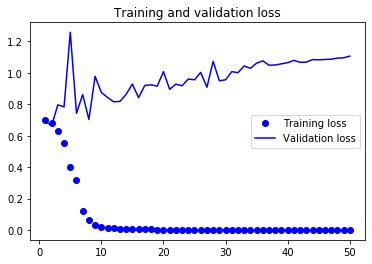

In [13]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
print("Validation Accuracy : ",np.max(val_acc))

Validation Accuracy :  0.6363636255264282


### 3. Update Model

- Model looks like over-fitting. Let's try drop-out technique and use small epochs

In [15]:
input_size = max_l+pad # for Input layers
max_vocab_size = len(vocab) + 1 # for Embedding layers

main_input = Input(shape=(input_size,), dtype='int32')
sequential_1 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_1 = Conv1D(200, 1, activation='relu')(sequential_1)
sequential_1 = MaxPooling1D(1)(sequential_1)
sequential_1 = Flatten()(sequential_1)

sequential_2 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_2 = Conv1D(200, 2, activation='relu')(sequential_2)
sequential_2 = MaxPooling1D(1)(sequential_2)
sequential_2 = Flatten()(sequential_2)

sequential_3 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_3 = Conv1D(200, 3, activation='relu')(sequential_3)
sequential_3 = MaxPooling1D(1)(sequential_3)
sequential_3 = Flatten()(sequential_3)

merged = layers.concatenate([sequential_1, sequential_2, sequential_3])
merged = Dropout(0.5)(merged)
dense = Dense(100, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=main_input, outputs=outputs)    

model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Train on 150 samples, validate on 33 samples
Epoch 1/20
150/150 [==============================] - 3s 22ms/step - loss: 0.9601 - accuracy: 0.4867 - val_loss: 0.6848 - val_accuracy: 0.6364
Epoch 2/20
150/150 [==============================] - 3s 19ms/step - loss: 0.6902 - accuracy: 0.5133 - val_loss: 0.6938 - val_accuracy: 0.3636
Epoch 3/20
150/150 [==============================] - 3s 20ms/step - loss: 0.6919 - accuracy: 0.5800 - val_loss: 0.6920 - val_accuracy: 0.5758
Epoch 4/20
150/150 [==============================] - 3s 21ms/step - loss: 0.6890 - accuracy: 0.6000 - val_loss: 0.6845 - val_accuracy: 0.6970
Epoch 5/20
150/150 [==============================] - 3s 22ms/step - loss: 0.6825 - accuracy: 0.6267 - val_loss: 0.6797 - val_accuracy: 0.6364
Epoch 6/20
150/150 [==============================] - 3s 21ms/step - loss: 0.6754 - accuracy: 0.5400 - val_loss: 0.6881 - val_accuracy: 0.6364
Epoch 7/20
150/150 [==============================] - 3s 20ms/step - loss: 0.6664 - accuracy: 0.7

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
np.mean(val_acc)

epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

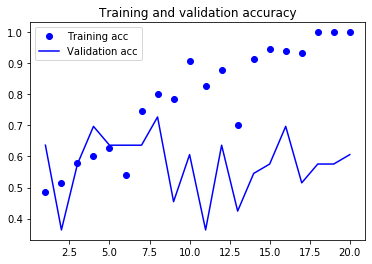

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

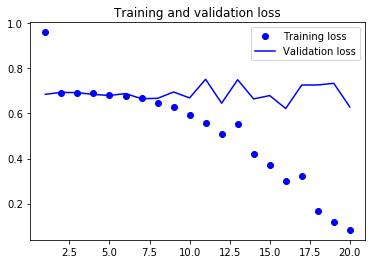

In [18]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
print("Validation Accuracy : ",np.max(val_acc))

Validation Accuracy :  0.7272727489471436


- Use more filters to obtain better performance

In [20]:
input_size = max_l+pad # for Input layers
max_vocab_size = len(vocab) + 1 # for Embedding layers

main_input = Input(shape=(input_size,), dtype='int32')
sequential_1 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_1 = Conv1D(400, 1, activation='relu')(sequential_1)
sequential_1 = MaxPooling1D(1)(sequential_1)
sequential_1 = Flatten()(sequential_1)

sequential_2 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_2 = Conv1D(400, 2, activation='relu')(sequential_2)
sequential_2 = MaxPooling1D(1)(sequential_2)
sequential_2 = Flatten()(sequential_2)

sequential_3 = Embedding(max_vocab_size, 200, input_length = max_l+2)(main_input)
sequential_3 = Conv1D(400, 3, activation='relu')(sequential_3)
sequential_3 = MaxPooling1D(1)(sequential_3)
sequential_3 = Flatten()(sequential_3)

merged = layers.concatenate([sequential_1, sequential_2, sequential_3])
merged = Dropout(0.5)(merged)
dense = Dense(100, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=main_input, outputs=outputs)    

model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=16,
                    validation_data=(x_val, y_val))

Train on 150 samples, validate on 33 samples
Epoch 1/20
150/150 [==============================] - 10s 68ms/step - loss: 1.2230 - accuracy: 0.4533 - val_loss: 0.6932 - val_accuracy: 0.4242
Epoch 2/20
150/150 [==============================] - 9s 58ms/step - loss: 0.6904 - accuracy: 0.6533 - val_loss: 0.6772 - val_accuracy: 0.6364
Epoch 3/20
150/150 [==============================] - 8s 55ms/step - loss: 0.6824 - accuracy: 0.5933 - val_loss: 0.6810 - val_accuracy: 0.7273
Epoch 4/20
150/150 [==============================] - 8s 56ms/step - loss: 0.6738 - accuracy: 0.6000 - val_loss: 0.6935 - val_accuracy: 0.4848
Epoch 5/20
150/150 [==============================] - 9s 57ms/step - loss: 0.6660 - accuracy: 0.7200 - val_loss: 0.6703 - val_accuracy: 0.6364
Epoch 6/20
150/150 [==============================] - 9s 57ms/step - loss: 0.6498 - accuracy: 0.7733 - val_loss: 0.6773 - val_accuracy: 0.6364
Epoch 7/20
150/150 [==============================] - 9s 58ms/step - loss: 0.6222 - accuracy: 0.

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
np.mean(val_acc)

epochs = range(1, len(acc) + 1)

<Figure size 432x288 with 0 Axes>

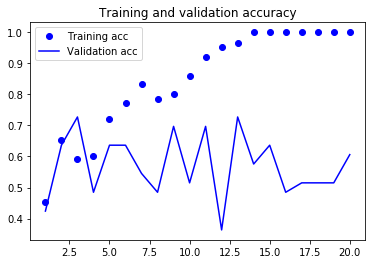

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

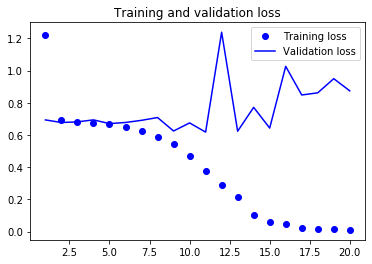

In [23]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
print("Validation Accuracy : ",np.max(val_acc))

Validation Accuracy :  0.7272727489471436
